<a href="https://colab.research.google.com/github/Dharva12/DCASE-Resnet/blob/main/DCASE_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
!jupyter nbconvert --to script DCASE2019_network.ipynb


[NbConvertApp] WARNING | pattern 'DCASE2019_network.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execu

In [5]:
!jupyter nbconvert --to script DCASE_training_functions.ipynb

[NbConvertApp] WARNING | pattern 'DCASE_training_functions.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]


In [7]:
import DCASE2019_network


In [8]:
from DCASE2019_network import model_resnet
from DCASE_training_functions import LR_WarmRestart, MixupGenerator

In [9]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import librosa
import soundfile as sound

import keras
import tensorflow
from keras.optimizers import SGD


print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

Librosa version =  0.10.2
Pysoundfile version =  0.12.1
keras version =  2.15.0
tensorflow version =  2.15.0


In [53]:
WhichTask = '1a'
#WhichTask = '1b'
#WhichTask = '1c'

if WhichTask =='1a':
    ThisPath = '/content/drive/MyDrive/dataset_root/TAU-urban-acoustic-scenes-2019-development_(Subtask A)/audio /'
    TrainFile = '/content/drive/MyDrive/dataset_root/TAU-urban-acoustic-scenes-2019-development_(Subtask A)/evaluation_setup/fold1_train.csv'
    ValFile = '/content/drive/MyDrive/dataset_root/TAU-urban-acoustic-scenes-2019-development_(Subtask A)/evaluation_setup/fold1_evaluate.csv'
    sr = 48000
    num_audio_channels = 2
elif WhichTask =='1b':
    ThisPath = '../Task1b/'
    TrainFile = ThisPath + 'evaluation_setup/fold1_train.csv'
    ValFile = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
    sr = 44100
    num_audio_channels = 1
elif WhichTask =='1c':
    ThisPath = '../Task1c/'
    TrainFile = ThisPath + 'evaluation_setup/fold1_train.csv'
    sr = 44100
    num_audio_channels = 1

SampleDuration = 10

#log-mel spectrogram parameters
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

#training parameters
max_lr = 0.1
batch_size = 32
num_epochs = 510
mixup_alpha = 0.4
crop_length = 400

In [35]:
#load filenames and labels
dev_train_df = pd.read_csv(TrainFile, sep=',', encoding='ASCII')
dev_val_df = pd.read_csv(ValFile, sep=',', encoding='ASCII')
wavpaths_train = dev_train_df['filename'].tolist()
wavpaths_val = dev_val_df['filename'].tolist()
y_train_labels =  dev_train_df['scene_label'].astype('category').cat.codes.values
y_val_labels =  dev_val_df['scene_label'].astype('category').cat.codes.values

ClassNames = np.unique(dev_train_df['scene_label'])
NumClasses = len(ClassNames)

y_train = keras.utils.to_categorical(y_train_labels, NumClasses)
y_val = keras.utils.to_categorical(y_val_labels, NumClasses)

In [36]:
import numpy as np

unique_rows = np.unique(y_val, axis=0)

# Print the unique rows
print(unique_rows)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [37]:
#load wav files and get log-mel spectrograms, deltas, and delta-deltas
def deltas(X_in):
    X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
    X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
    return X_out

LM_train = np.zeros((len(wavpaths_train),NumFreqBins,NumTimeBins,num_audio_channels),'float32')
for i in range(len(wavpaths_train)):
    stereo,fs = sound.read(ThisPath + wavpaths_train[i],stop=SampleDuration*sr)
    for channel in range(num_audio_channels):
        if len(stereo.shape)==1:
            stereo = np.expand_dims(stereo,-1)
        LM_train[i,:,:,channel]= librosa.feature.melspectrogram(y=stereo[:,channel],
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_train = np.log(LM_train+1e-8)
LM_deltas_train = deltas(LM_train)
LM_deltas_deltas_train = deltas(LM_deltas_train)
LM_train = np.concatenate((LM_train[:,:,4:-4,:],LM_deltas_train[:,:,2:-2,:],LM_deltas_deltas_train),axis=-1)

LM_val = np.zeros((len(wavpaths_val),NumFreqBins,NumTimeBins,num_audio_channels),'float32')
for i in range(len(wavpaths_val)):
    stereo,fs = sound.read(ThisPath + wavpaths_val[i],stop=SampleDuration*sr)
    for channel in range(num_audio_channels):
        if len(stereo.shape)==1:
            stereo = np.expand_dims(stereo,-1)
        LM_val[i,:,:,channel]= librosa.feature.melspectrogram(y=stereo[:,channel],
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_val = np.log(LM_val+1e-8)
LM_deltas_val = deltas(LM_val)
LM_deltas_deltas_val = deltas(LM_deltas_val)
LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)


In [38]:
max_time_bins_train = max(LM_train.shape[2] for LM_train in LM_train)
max_time_bins_val = max(LM_val.shape[2] for LM_val in LM_val)

print("Maximum number of time bins in training data:", max_time_bins_train)
print("Maximum number of time bins in validation data:", max_time_bins_val)


Maximum number of time bins in training data: 6
Maximum number of time bins in validation data: 6


In [40]:
#create and compile the model
model = model_resnet(NumClasses,
                     input_shape =[NumFreqBins,None,3*num_audio_channels],
                     num_filters =24,
                     wd=1e-3)
from keras.optimizers import SGD

# Define optimizer with learning_rate instead of lr and remove decay
optimizer = SGD(learning_rate=max_lr, momentum=0.9, nesterov=False)

# Compile the model using the defined optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, None, 6)]       0         []                            
                                                                                                  
 lambda_8 (Lambda)           (None, 64, None, 6)          0         ['input_2[0][0]']             
                                                                                                  
 lambda_9 (Lambda)           (None, 64, None, 6)          0         ['input_2[0][0]']             
                                                                                                  
 batch_normalization_37 (Ba  (None, 64, None, 6)          24        ['lambda_8[0][0]']            
 tchNormalization)                                                                          

In [41]:
#set learning rate schedule
lr_scheduler = LR_WarmRestart(nbatch=np.ceil(LM_train.shape[0]/batch_size), Tmult=2,
                              initial_lr=max_lr, min_lr=max_lr*1e-4,
                              epochs_restart = [3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0,511.0])
callbacks = [lr_scheduler]

#create data generator
TrainDataGen = MixupGenerator(LM_train,
                              y_train,
                              batch_size=batch_size,
                              alpha=mixup_alpha,
                              crop_length=crop_length)()

#train the model
history = model.fit_generator(TrainDataGen,
                              validation_data=(LM_val, y_val),
                              epochs=num_epochs,
                              verbose=1,
                              workers=4,
                              max_queue_size = 100,
                              callbacks=callbacks,
                              steps_per_epoch=np.ceil(LM_train.shape[0]/batch_size)
                              )

<ipython-input-41-f992368096ca>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(TrainDataGen,


Epoch 1/510
97/97 [==============================] - ETA: 0s - loss: 8.2873 - accuracy: 0.4253
LearningRate:0.050815
97/97 [==============================] - 29s 174ms/step - loss: 8.2873 - accuracy: 0.4253 - val_loss: 10.4009 - val_accuracy: 0.1286
Epoch 2/510
97/97 [==============================] - ETA: 0s - loss: 6.8672 - accuracy: 0.5219
LearningRate:0.000017
97/97 [==============================] - 12s 126ms/step - loss: 6.8672 - accuracy: 0.5219 - val_loss: 6.9585 - val_accuracy: 0.3029
Epoch 3/510
97/97 [==============================] - ETA: 0s - loss: 6.0303 - accuracy: 0.5087
LearningRate:0.085642
97/97 [==============================] - 16s 161ms/step - loss: 6.0303 - accuracy: 0.5087 - val_loss: 5.6451 - val_accuracy: 0.2523
Epoch 4/510
97/97 [==============================] - ETA: 0s - loss: 4.7423 - accuracy: 0.5677
LearningRate:0.050410
97/97 [==============================] - 16s 166ms/step - loss: 4.7423 - accuracy: 0.5677 - val_loss: 4.6614 - val_accuracy: 0.2714
Epo

In [43]:
model.save('/content/drive/MyDrive/' + WhichTask + '_Task_development_1.keras')



In [45]:
from google.colab import files
files.download('/content/drive/MyDrive/' + WhichTask + '_Task_development_1.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
import numpy as np
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import librosa
import soundfile as sound
import keras
import tensorflow
print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

Librosa version =  0.10.2
Pysoundfile version =  0.12.1
keras version =  2.15.0
tensorflow version =  2.15.0


In [54]:
#Task 1a dev validation set
File = '/content/drive/MyDrive/dataset_root/TAU-urban-acoustic-scenes-2019-development_(Subtask A)/evaluation_setup/fold1_evaluate.csv'
sr = 48000
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [55]:
#load filenames and labels
dev_test_df = pd.read_csv(File,sep=',', encoding='ASCII')
wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values

#swap codes for 2 and 1 to match the DCASE ordering of classes
a1=np.where(y_val_labels==2)
a2=np.where(y_val_labels==3)
y_val_labels.setflags(write=1)
y_val_labels[a1] = 3
y_val_labels[a2] = 2

In [57]:
#load wav files and get log-mel spectrograms, deltas, and delta-deltas
def deltas(X_in):
    X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
    X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
    return X_out

LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
for i in range(len(wavpaths)):
    stereo,fs = sound.read(ThisPath + wavpaths[i],stop=SampleDuration*sr)
    for channel in range(2):
        LM_val[i, :, :, channel] = librosa.feature.melspectrogram(y=stereo[:, channel],
                                                          sr=sr,
                                                          n_fft=NumFFTPoints,
                                                          hop_length=HopLength,
                                                          n_mels=NumFreqBins,
                                                          fmin=0.0,
                                                          fmax=sr/2,
                                                          htk=True,
                                                          norm=None)


LM_val=np.log(LM_val)
LM_deltas_val = deltas(LM_val)
LM_deltas_deltas_val = deltas(LM_deltas_val)
LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)

In [61]:
# Use the trained model to make predictions on the validation data (LM_val)
y_pred_val = np.argmax(model.predict(LM_val), axis=1)


38/38 [==============================] - 1s 32ms/step


overall accuracy:  0.6514522821576764
Normalized confusion matrix
per-class accuracy (recall):  [0.84347826 0.75892857 0.0075188  0.13592233 1.         0.24074074
 0.95321637 0.65048544 0.98550725 0.77192982]
per-class precision:  [0.87387387 0.83333333 0.0106383  0.0979021  0.83076923 0.66666667
 0.95321637 0.57758621 0.74725275 0.75213675]
mean per-class recall:  0.634772758222887
mean per-class precision:  0.63433755809726


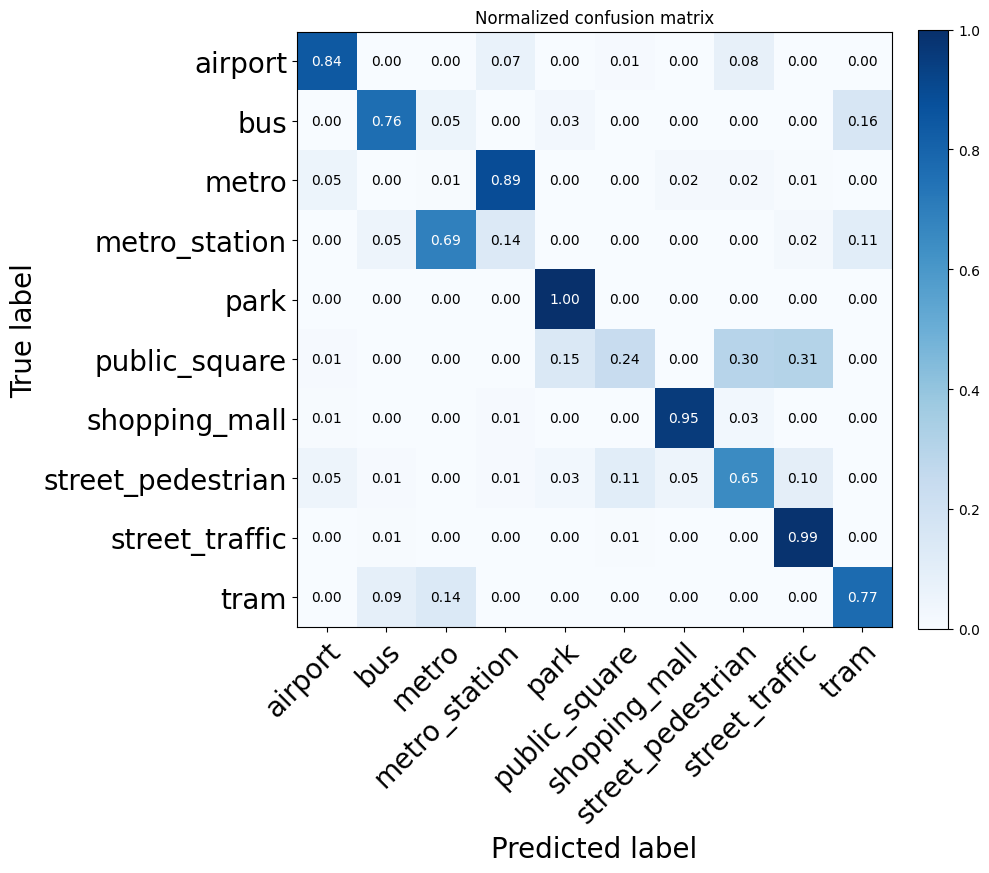

In [62]:
#get metrics
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)

conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)